# 로이터 뉴스 분류: Vocabulary 크기에 따른 모델 성능 비교

## 목표
- `reuters.load_data`의 `num_words` 파라미터를 변경해가며 단어의 수를 조절
- 다양한 Vocabulary 크기에 따라 여러 머신러닝 분류 모델의 성능이 어떻게 변하는지 체계적으로 비교하고 분석

## 루브릭
| 학습목표 | 평가기준 |
| :--- | :--- |
| 분류 모델의 accuracy가 기준 이상 높게 나왔는가? | 3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다. |
| 분류 모델의 F1 score가 기준 이상 높게 나왔는가? | Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다. |
| 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가? | 동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다. |

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.datasets import reuters
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score

## 1. 실험 설계

- **Vocabulary 크기**: `num_words`를 1000, 5000, 10000, 20000, 전체단어로 변경하며 테스트
- **비교 모델 리스트**: 8개 머신러닝 모델 사용
    - `MultinomailNB`
    - `ComplementNB`
    - `LogisticRegression`
    - `LinearSVC`
    - `DecisionTree`
    - `RandomForest`
    - `GradientBoosting`
    - `VotingClassifier`

In [2]:
def run_experiment(num_words):
    """
    지정된 num_words로 데이터를 로드하고, TF-IDF로 변환한 뒤 
    다양한 모델의 정확도를 측정하여 반환
    """
    if num_words:
        print(f'--- Vocab Size = {num_words} 실험 시작 ---')
    else:
        print('--- Vocab Size = 모든 단어 실험 시작')

    # 1. 데이터 로드
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)
    print(f'Train samples: {len(x_train)}, Test samples: {len(x_test)}')

    # 2. 데이터를 TF-IDF 행렬로 변환
    x_train_str = [' '.join(map(str, doc)) for doc in x_train]
    x_test_str = [' '.join(map(str, doc)) for doc in x_test]

    vectorizer = CountVectorizer(token_pattern=r'[0-9]+').fit(x_train_str)
    x_train_dtm = vectorizer.transform(x_train_str)
    x_test_dtm = vectorizer.transform(x_test_str)

    tfidf_transformer = TfidfTransformer()
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
    x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

    # 3. 모델 학습 및 평가
    models = [
        ('MultinomialNB', MultinomialNB()),
        ('ComplementNB', ComplementNB()),
        ('LogisticRegression', LogisticRegression(C=10000, penalty='l2', max_iter=3000, random_state=42)),
        ('LinearSVC', LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False, random_state=42)),
        ('DecisionTree', DecisionTreeClassifier(max_depth=10, random_state=0)),
        ('RandomForest', RandomForestClassifier(n_estimators=5, random_state=0)),
        ('GradientBoosting', GradientBoostingClassifier(random_state=0)),
        ('VotingClassifier', VotingClassifier(estimators=[
             ('lr', LogisticRegression(C=10000, penalty='l2', max_iter=3000)),
             ('cb', ComplementNB()),
             ('grbt', GradientBoostingClassifier(random_state=0))
            ], voting='soft', n_jobs=-1))
    ]

    results = {}
    for name, model in models:
        print(f'Training {name}...')
        try:
            model.fit(x_train_tfidf, y_train)
            predicted = model.predict(x_test_tfidf)
            accuracy = accuracy_score(y_test, predicted)
            results[name] = accuracy
            print(f'{name} Accuracy: {accuracy:.4f}')
        except Exception as e:
            print(f'{name} failed with error: {e}')
            results[name] = str(e)
        
    return results

In [3]:
# 실험 실행
vocab_sizes = [1000, 5000, 10000, 20000, None]
all_results = {}

for size in vocab_sizes:
    all_results[size] = run_experiment(size)

--- Vocab Size = 1000 실험 시작 ---
Train samples: 8982, Test samples: 2246
Training MultinomialNB...
MultinomialNB Accuracy: 0.6834
Training ComplementNB...
ComplementNB Accuracy: 0.7342
Training LogisticRegression...
LogisticRegression Accuracy: 0.7524
Training LinearSVC...


/Users/bychoi/miniforge3/envs/goingdeeper/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC Accuracy: 0.7008
Training DecisionTree...
DecisionTree Accuracy: 0.6118
Training RandomForest...
RandomForest Accuracy: 0.7012
Training GradientBoosting...
GradientBoosting Accuracy: 0.7511
Training VotingClassifier...
VotingClassifier Accuracy: 0.7685
--- Vocab Size = 5000 실험 시작 ---
Train samples: 8982, Test samples: 2246
Training MultinomialNB...
MultinomialNB Accuracy: 0.6692
Training ComplementNB...
ComplementNB Accuracy: 0.7703
Training LogisticRegression...
LogisticRegression Accuracy: 0.8059
Training LinearSVC...


/Users/bychoi/miniforge3/envs/goingdeeper/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC Accuracy: 0.7743
Training DecisionTree...
DecisionTree Accuracy: 0.6113
Training RandomForest...
RandomForest Accuracy: 0.6963
Training GradientBoosting...
GradientBoosting Accuracy: 0.7573
Training VotingClassifier...
VotingClassifier Accuracy: 0.8143
--- Vocab Size = 10000 실험 시작 ---
Train samples: 8982, Test samples: 2246
Training MultinomialNB...
MultinomialNB Accuracy: 0.6509
Training ComplementNB...
ComplementNB Accuracy: 0.7716
Training LogisticRegression...
LogisticRegression Accuracy: 0.8081
Training LinearSVC...


/Users/bychoi/miniforge3/envs/goingdeeper/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC Accuracy: 0.7881
Training DecisionTree...
DecisionTree Accuracy: 0.6086
Training RandomForest...
RandomForest Accuracy: 0.6683
Training GradientBoosting...
GradientBoosting Accuracy: 0.7551
Training VotingClassifier...
VotingClassifier Accuracy: 0.8085
--- Vocab Size = 20000 실험 시작 ---
Train samples: 8982, Test samples: 2246
Training MultinomialNB...
MultinomialNB Accuracy: 0.6100
Training ComplementNB...
ComplementNB Accuracy: 0.7676
Training LogisticRegression...
LogisticRegression Accuracy: 0.8099
Training LinearSVC...


/Users/bychoi/miniforge3/envs/goingdeeper/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC Accuracy: 0.7898
Training DecisionTree...
DecisionTree Accuracy: 0.6082
Training RandomForest...
RandomForest Accuracy: 0.6554
Training GradientBoosting...
GradientBoosting Accuracy: 0.7685
Training VotingClassifier...
VotingClassifier Accuracy: 0.8206
--- Vocab Size = 모든 단어 실험 시작
Train samples: 8982, Test samples: 2246
Training MultinomialNB...
MultinomialNB Accuracy: 0.5926
Training ComplementNB...
ComplementNB Accuracy: 0.7582
Training LogisticRegression...
LogisticRegression Accuracy: 0.8108
Training LinearSVC...


/Users/bychoi/miniforge3/envs/goingdeeper/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC Accuracy: 0.7890
Training DecisionTree...
DecisionTree Accuracy: 0.6131
Training RandomForest...
RandomForest Accuracy: 0.6732
Training GradientBoosting...
GradientBoosting Accuracy: 0.7671
Training VotingClassifier...
VotingClassifier Accuracy: 0.8183


## 2. 최종 결과 비교

In [11]:
# 결과를 보기 좋게 DataFrame으로 변환
results_df = pd.DataFrame(all_results).T
results_df.index.name = 'Vocabulary Size'
print(results_df)

                 MultinomialNB  ComplementNB  LogisticRegression  LinearSVC  \
Vocabulary Size                                                               
1000.0                0.683437      0.734194            0.752449   0.700801   
5000.0                0.669190      0.770258            0.805877   0.774265   
10000.0               0.650935      0.771594            0.808103   0.788068   
20000.0               0.609973      0.767587            0.809884   0.789849   
NaN                   0.592609      0.758237            0.810775   0.788958   

                 DecisionTree  RandomForest  GradientBoosting  \
Vocabulary Size                                                 
1000.0               0.611754      0.701247          0.751113   
5000.0               0.611309      0.696349          0.757346   
10000.0              0.608638      0.668299          0.755120   
20000.0              0.608192      0.655387          0.768477   
NaN                  0.613090      0.673197          0.7

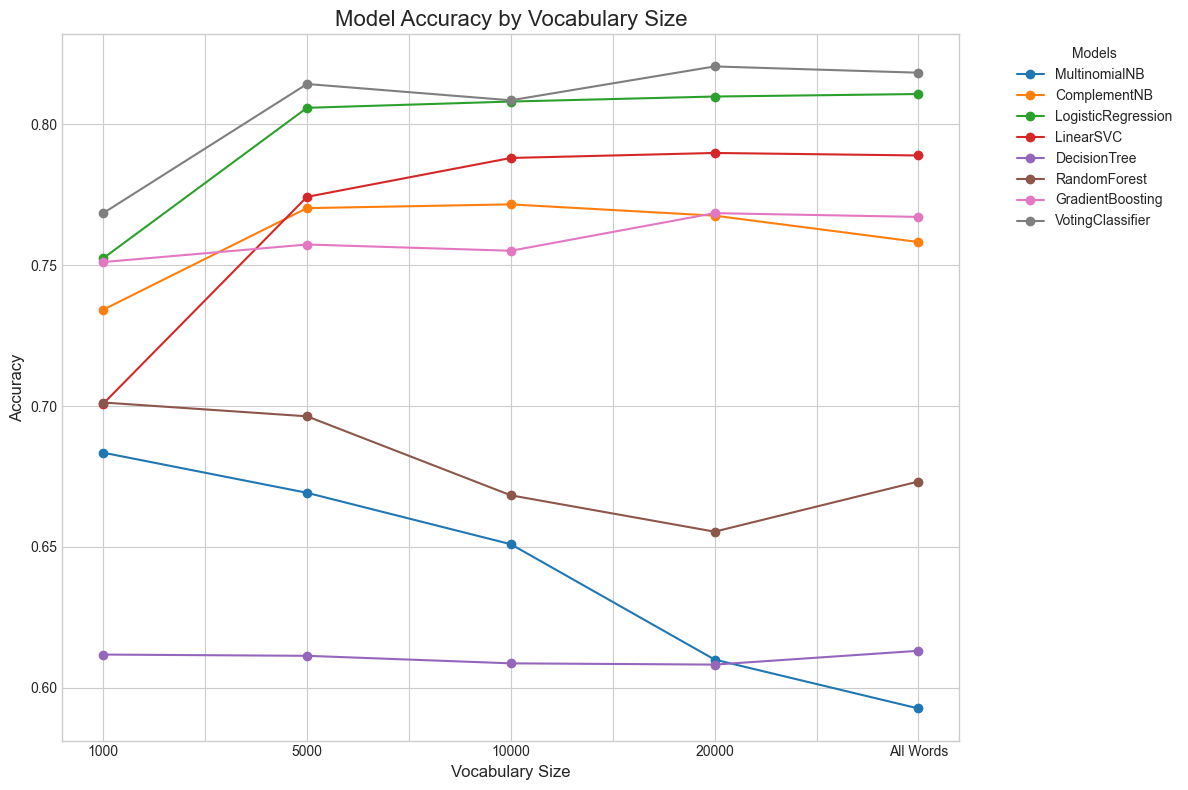

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plot_df = results_df.copy()
new_index = [str(int(idx)) if pd.notna(idx) else 'All Words' for idx in plot_df.index]
plot_df.index = new_index

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')

# 라인 플롯 그리기
plot_df.plot(kind='line', marker='o', figsize=(12, 8))

# 타이틀과 라벨을 영어로 변경
plt.title('Model Accuracy by Vocabulary Size', fontsize=16)
plt.xlabel('Vocabulary Size', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=0) # X축 라벨이 회전되지 않도록 설정
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

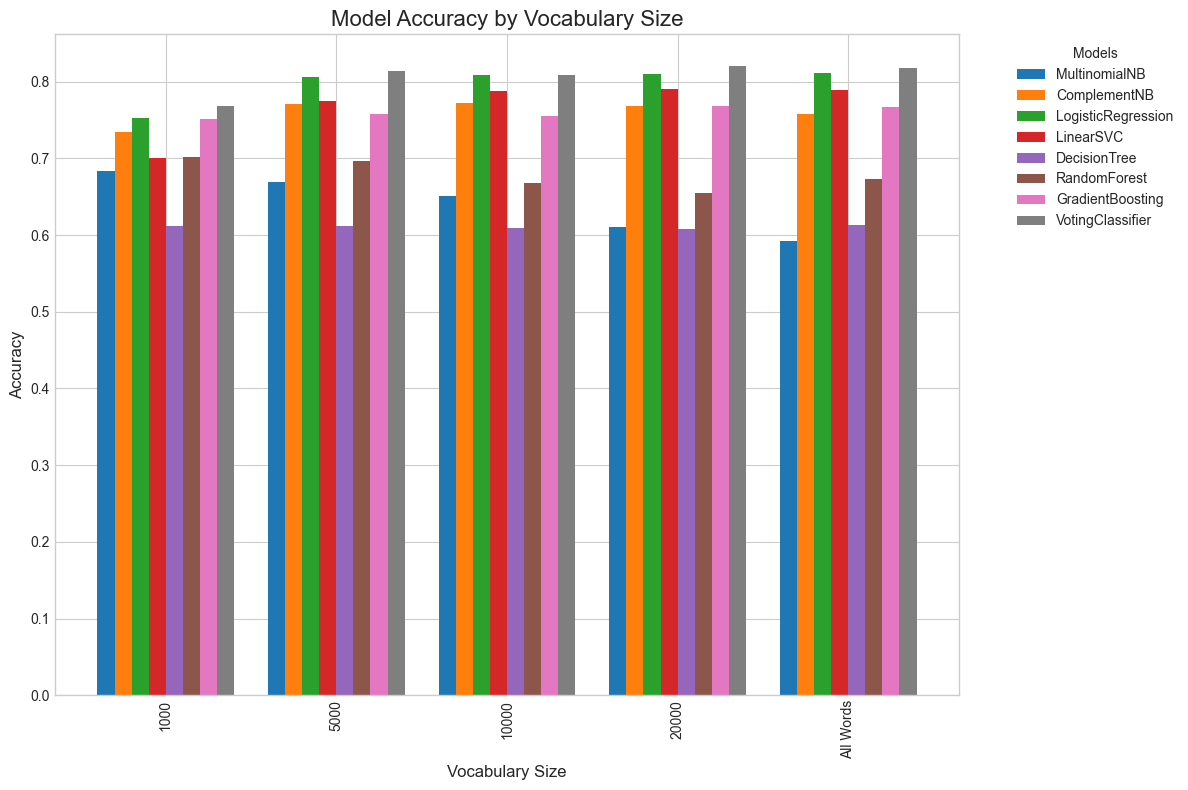

In [ ]:
plot_df = results_df.copy()
new_index = [str(int(idx)) if pd.notna(idx) else 'All Words' for idx in plot_df.index]
plot_df.index = new_index

# 막대 그래프 설정
plot_df.plot(kind='bar', figsize=(12, 8), width=0.8)

plt.title('Model Accuracy by Vocabulary Size', fontsize=16)
plt.xlabel('Vocabulary Size', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

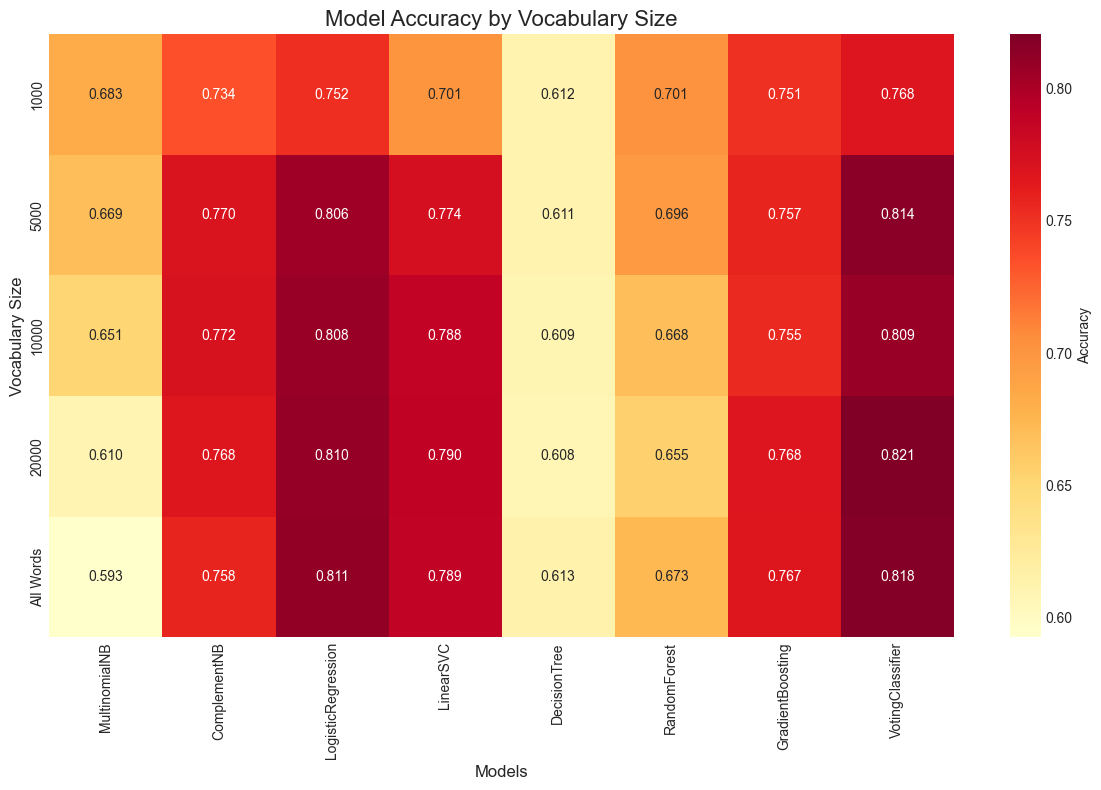

In [ ]:
plot_df = results_df.copy()
new_index = [str(int(idx)) if pd.notna(idx) else 'All Words' for idx in plot_df.index]
plot_df.index = new_index

# 히트맵 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(plot_df, annot=True, cmap='YlOrRd', fmt='.3f', cbar_kws={'label': 'Accuracy'})

# 타이틀과 라벨 설정
plt.title('Model Accuracy by Vocabulary Size', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Vocabulary Size', fontsize=12)
plt.tight_layout()
plt.show()